In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from pandas import *
%matplotlib inline

### 对回归、二分类、多分类任务分别选择上述实验中效果最好的模型，采用10折交叉验证评估实验结果

要求除了最终结果外还需以表格的形式展示每折的实验结果

In [80]:
#模型训练
def train(train_iter,test_iter,if_reshape,num_epochs,num_inputs,net,loss):
    optimizer = torch.optim.SGD(net.parameters(),lr=0.001)
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        ls, count = 0, 0
        if if_reshape ==False:
            for X,y in train_iter:
                l=loss(net(X),y.view(-1,1))
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                ls += l.item()
                count += y.shape[0]
            train_ls.append(ls/count)
            ls, count = 0, 0
            for X,y in test_iter:
                l=loss(net(X),y.view(-1,1))
                ls += l.item()
                count += y.shape[0]
        else:
            for X,y in train_iter:
                X = X.reshape(-1,num_inputs)
                l=loss(net(X),y).sum()
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                ls += l.item()
                count += y.shape[0]
            train_ls.append(ls/count)
            ls, count = 0, 0
            for X,y in test_iter:
                X = X.reshape(-1,num_inputs)
                l=loss(net(X),y).sum()
                ls += l.item()
                count += y.shape[0]
        test_ls.append(ls/count)
        print('epoch: %d, train loss: %f, valid loss: %f'%(epoch+1,train_ls[-1],test_ls[-1]))
    return train_ls,test_ls

In [81]:
def get_kfold_data(k, i, X, y):
    fold_size = X.shape[0]//k
    val_start = i * fold_size
    if i  != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end],y[val_start:val_end]
        X_train = torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train = torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid = X[val_start:], y[val_start:]
        X_train = X[0:val_start]
        y_train = y[0:val_start]
    
    return X_train, y_train, X_valid, y_valid

In [82]:
def k_fold(k, X_train, y_train,if_reshape,num_epochs,num_inputs,net,loss):
    record_k_train_ls, record_k_valid_ls = [], []
    train_loss_sum, valid_loss_sum = 0, 0
    for i in range(k):
        print('第', i+1, '折验证结果')
        X_train, y_train, X_valid, y_valid = get_kfold_data(k, i, X_train, y_train)
        train_iter, valid_iter = gen_data_iter(X_train, y_train, X_valid, y_valid,batch_size=100)
        train_loss, val_loss = train(train_iter,valid_iter,if_reshape,num_epochs,num_inputs,net,loss)
        
        record_k_train_ls.append(train_loss)
        record_k_valid_ls.append(val_loss)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += val_loss[-1]
    
    print('\n','最终k折交叉验证结果')
    
    print(f'average train loss: {train_loss_sum/k}')
    print(f'average valid loss: {valid_loss_sum/k}')
    
    return record_k_train_ls, record_k_valid_ls

In [5]:
def gen_data_iter(X_train, y_train, X_valid, y_valid,batch_size):
    train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
    test_dataset = torch.utils.data.TensorDataset(X_valid,y_valid)
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    return train_iter, test_iter

**回归任务**

In [6]:
#加载数据集
features = torch.rand(10000, 500)
labels = (0.0056 * features).sum(dim=1) + 0.028
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float)

index = [i for i in range(len(features))]
random.shuffle(index)
features = features[index]
labels = labels[index]

In [7]:
# 定义网络
class LinearNet(nn.Module):
    def __init__(self,n_feature,num_model):
        super(LinearNet,self).__init__()
        self.num_model = num_model
        self.model1 = nn.Sequential(
                        nn.Linear(n_feature,250),
                        nn.Sigmoid(),
                        nn.Linear(250,1))
        self.model2 = nn.Sequential(
                        nn.Linear(n_feature,250),
                        nn.Tanh(),
                        nn.Linear(250,1))
        self.model3 = nn.Sequential(
                        nn.Linear(n_feature,250),
                        nn.ReLU(),
                        nn.Linear(250,1))
    
    def forward(self,x):
        assert self.num_model <= 3
        if self.num_model == 1:
            y = self.model1(x)
        elif self.num_model == 2:
            y = self.model2(x)
        else:
            y = self.model3(x)
        return y

In [83]:
record_k_train_ls, record_k_valid_ls = k_fold(10, features, labels,if_reshape=False,num_epochs=5,num_inputs = 500,net = LinearNet(500,2),loss= nn.MSELoss())

第 1 折验证结果
epoch: 1, train loss: 0.000649, valid loss: 0.000070
epoch: 2, train loss: 0.000072, valid loss: 0.000069
epoch: 3, train loss: 0.000071, valid loss: 0.000068
epoch: 4, train loss: 0.000069, valid loss: 0.000066
epoch: 5, train loss: 0.000068, valid loss: 0.000065
第 2 折验证结果
epoch: 1, train loss: 0.000067, valid loss: 0.000069
epoch: 2, train loss: 0.000065, valid loss: 0.000067
epoch: 3, train loss: 0.000064, valid loss: 0.000066
epoch: 4, train loss: 0.000063, valid loss: 0.000065
epoch: 5, train loss: 0.000062, valid loss: 0.000064
第 3 折验证结果
epoch: 1, train loss: 0.000060, valid loss: 0.000073
epoch: 2, train loss: 0.000059, valid loss: 0.000072
epoch: 3, train loss: 0.000059, valid loss: 0.000071
epoch: 4, train loss: 0.000058, valid loss: 0.000070
epoch: 5, train loss: 0.000057, valid loss: 0.000069
第 4 折验证结果
epoch: 1, train loss: 0.000056, valid loss: 0.000067
epoch: 2, train loss: 0.000055, valid loss: 0.000066
epoch: 3, train loss: 0.000054, valid loss: 0.000065
epoch:

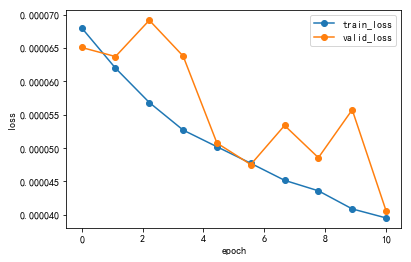

In [85]:
# 绘图
train_loss, valid_loss = [], []
for i in range(len(record_k_train_ls)):
    train_loss.append(record_k_train_ls[i][-1])
    valid_loss.append(record_k_valid_ls[i][-1])
    
x = np.linspace(0,len(record_k_train_ls),len(record_k_train_ls))
plt.plot(x,train_loss,'o-',label='train_loss',linewidth=1.5)
plt.plot(x,valid_loss,'o-',label='valid_loss',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

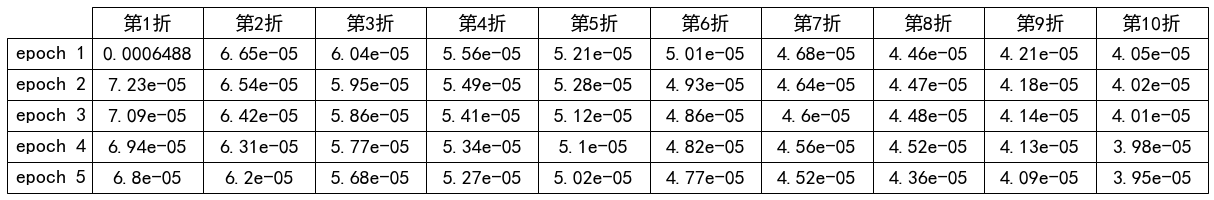

In [86]:
# 绘制表格
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
randn = np.random.randn
idx = []
for i in range(1,6):
    idx.append(f'epoch {i}')

data_train, data_valid = np.zeros((10,5)),np.zeros((10,5))
for i in range(10):
    for j in range(5):
        data_train[i,j], data_valid[i,j] = record_k_train_ls[i][j], record_k_valid_ls[i][j] 
       
    
df = DataFrame(data_train.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

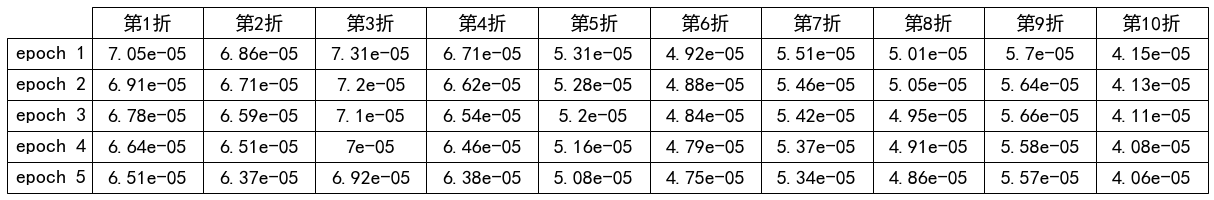

In [87]:
df = DataFrame(data_valid.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

**二分类任务**

In [61]:
#生成数据
x1 = torch.tensor(np.random.normal(2,1,(10000,200)), dtype=torch.float)
x1_labels = torch.ones((10000))
x2 = torch.tensor(np.random.normal(-2,1,(10000,200)), dtype=torch.float)
x2_labels = torch.zeros((10000))
class_2_features = torch.cat((x1,x2),dim=0)
class_2_labels = torch.cat((x1_labels,x2_labels))
index = [i for i in range(len(class_2_labels))]
np.random.shuffle(index)
class_2_features = class_2_features[index,:]
class_2_labels = class_2_labels[index]

In [62]:
# 定义网络
class class_LinearNet(nn.Module):
    def __init__(self,n_feature,num_model):
        super(class_LinearNet,self).__init__()
        self.num_model = num_model
        self.model1 = nn.Sequential(
                        nn.Linear(n_feature,100),
                        nn.ReLU(),
                        nn.Linear(100,1),
                        nn.Sigmoid())
        self.model2 = nn.Sequential(
                        nn.Linear(n_feature,100),
                        nn.Tanh(),
                        nn.Linear(100,1),
                        nn.Sigmoid())
        self.model3 = nn.Sequential(
                        nn.Linear(n_feature,100),
                        nn.LeakyReLU(0.2),
                        nn.Linear(100,1),
                        nn.Sigmoid())
    
    def forward(self,x):
        assert self.num_model <= 3
        if self.num_model == 1:
            y = self.model1(x)
        elif self.num_model == 2:
            y = self.model2(x)
        else:
            y = self.model3(x)
        return y

In [119]:
record_k_train_ls, record_k_valid_ls = k_fold(10, class_2_features, class_2_labels,if_reshape=False,num_epochs=5,num_inputs = 200,net = class_LinearNet(200,3),loss=nn.BCELoss())

第 1 折验证结果
epoch: 1, train loss: 0.002126, valid loss: 0.000413
epoch: 2, train loss: 0.000269, valid loss: 0.000179
epoch: 3, train loss: 0.000141, valid loss: 0.000110
epoch: 4, train loss: 0.000094, valid loss: 0.000079
epoch: 5, train loss: 0.000069, valid loss: 0.000060
第 2 折验证结果
epoch: 1, train loss: 0.000055, valid loss: 0.000050
epoch: 2, train loss: 0.000046, valid loss: 0.000042
epoch: 3, train loss: 0.000040, valid loss: 0.000037
epoch: 4, train loss: 0.000035, valid loss: 0.000032
epoch: 5, train loss: 0.000031, valid loss: 0.000029
第 3 折验证结果
epoch: 1, train loss: 0.000028, valid loss: 0.000027
epoch: 2, train loss: 0.000025, valid loss: 0.000025
epoch: 3, train loss: 0.000023, valid loss: 0.000023
epoch: 4, train loss: 0.000021, valid loss: 0.000021
epoch: 5, train loss: 0.000020, valid loss: 0.000020
第 4 折验证结果
epoch: 1, train loss: 0.000019, valid loss: 0.000019
epoch: 2, train loss: 0.000018, valid loss: 0.000018
epoch: 3, train loss: 0.000017, valid loss: 0.000017
epoch:

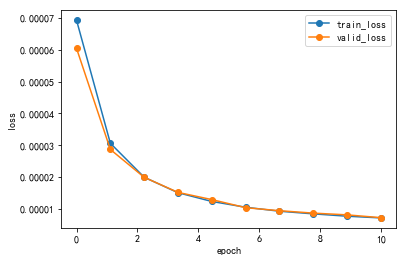

In [120]:
# 绘图
train_loss, valid_loss = [], []
for i in range(len(record_k_train_ls)):
    train_loss.append(record_k_train_ls[i][-1])
    valid_loss.append(record_k_valid_ls[i][-1])
    
x = np.linspace(0,len(record_k_train_ls),len(record_k_train_ls))
plt.plot(x,train_loss,'o-',label='train_loss',linewidth=1.5)
plt.plot(x,valid_loss,'o-',label='valid_loss',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

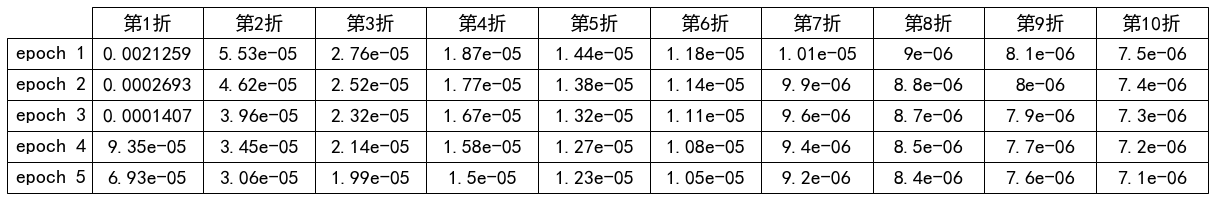

In [121]:
# 绘制表格
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
randn = np.random.randn
idx = []
for i in range(1,6):
    idx.append(f'epoch {i}')

data_train, data_valid = np.zeros((10,5)),np.zeros((10,5))
for i in range(10):
    for j in range(5):
        data_train[i,j], data_valid[i,j] = record_k_train_ls[i][j], record_k_valid_ls[i][j] 
       
    
df = DataFrame(data_train.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

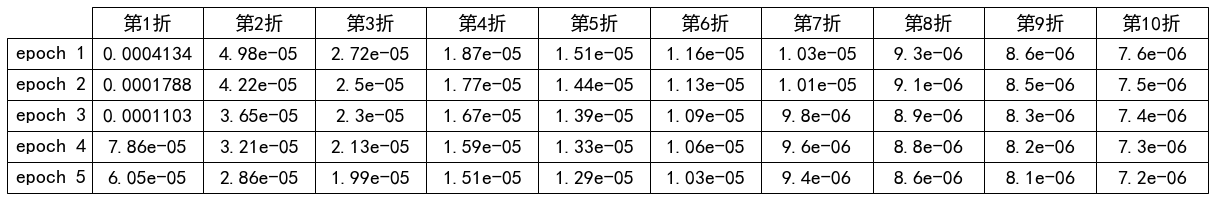

In [122]:
df = DataFrame(data_valid.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

**多分类任务**

In [92]:
#生成数据

#下载MNIST手写数字数据集
train_dataset = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True, transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False, transform = transforms.ToTensor(),download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [112]:
mnist_features = torch.cat((train_loader.dataset.data,test_loader.dataset.data),dim=0)
mnist_labels = torch.cat((train_loader.dataset.train_labels,test_loader.dataset.test_labels))

mnist_features = mnist_features.float()
mnist_labels = mnist_labels.long()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [123]:
#定义网络
class muti_class_LinearNet(nn.Module):
    def __init__(self,num_inputs, num_outputs, num_hiddens):
        super(muti_class_LinearNet,self).__init__()
        self.linear1 = nn.Linear(num_inputs,num_hiddens)
        self.leakrelu = nn.functional.leaky_relu
        self.linear2 = nn.Linear(num_hiddens,num_outputs)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.leakrelu(x,0.2)
        x = self.linear2(x)
        y = self.leakrelu(x,0.2)
        return y

In [124]:
record_k_train_ls, record_k_valid_ls = k_fold(10, mnist_features, mnist_labels,if_reshape=True, num_epochs=10, num_inputs = 784, net = muti_class_LinearNet(784, 10, 600),loss=nn.CrossEntropyLoss())

第 1 折验证结果
epoch: 1, train loss: 0.009346, valid loss: 0.002596
epoch: 2, train loss: 0.002463, valid loss: 0.002111
epoch: 3, train loss: 0.002008, valid loss: 0.001878
epoch: 4, train loss: 0.001729, valid loss: 0.001683
epoch: 5, train loss: 0.001527, valid loss: 0.001548
epoch: 6, train loss: 0.001373, valid loss: 0.001473
epoch: 7, train loss: 0.001249, valid loss: 0.001390
epoch: 8, train loss: 0.001144, valid loss: 0.001316
epoch: 9, train loss: 0.001060, valid loss: 0.001257
epoch: 10, train loss: 0.000983, valid loss: 0.001208
第 2 折验证结果
epoch: 1, train loss: 0.000913, valid loss: 0.000963
epoch: 2, train loss: 0.000856, valid loss: 0.000971
epoch: 3, train loss: 0.000806, valid loss: 0.000954
epoch: 4, train loss: 0.000760, valid loss: 0.000932
epoch: 5, train loss: 0.000721, valid loss: 0.000919
epoch: 6, train loss: 0.000684, valid loss: 0.000906
epoch: 7, train loss: 0.000648, valid loss: 0.000908
epoch: 8, train loss: 0.000619, valid loss: 0.000890
epoch: 9, train loss: 0.0

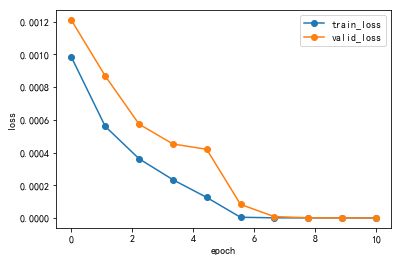

In [125]:
# 绘图
train_loss, valid_loss = [], []
for i in range(len(record_k_train_ls)):
    train_loss.append(record_k_train_ls[i][-1])
    valid_loss.append(record_k_valid_ls[i][-1])
    
x = np.linspace(0,len(record_k_train_ls),len(record_k_train_ls))
plt.plot(x,train_loss,'o-',label='train_loss',linewidth=1.5)
plt.plot(x,valid_loss,'o-',label='valid_loss',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

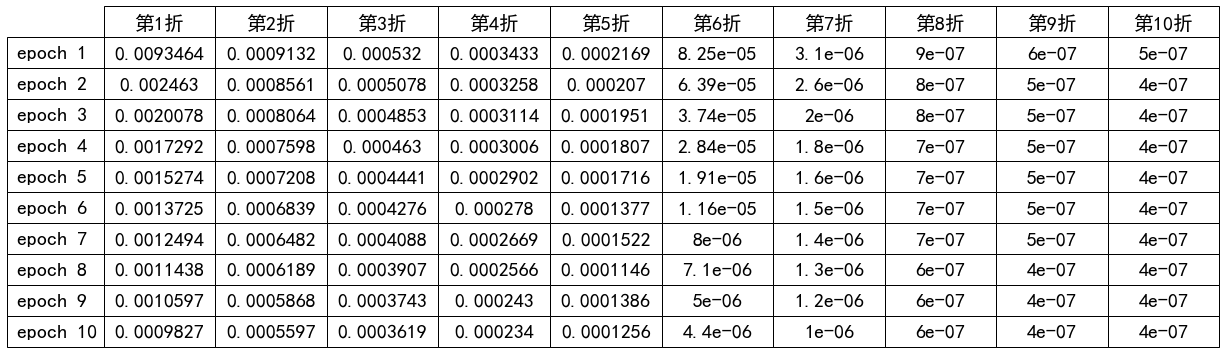

In [126]:
# 绘制表格
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
randn = np.random.randn
idx = []
for i in range(1,11):
    idx.append(f'epoch {i}')

data_train, data_valid = np.zeros((10,10)),np.zeros((10,10))
for i in range(10):
    for j in range(10):
        data_train[i,j], data_valid[i,j] = record_k_train_ls[i][j], record_k_valid_ls[i][j] 
       
    
df = DataFrame(data_train.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

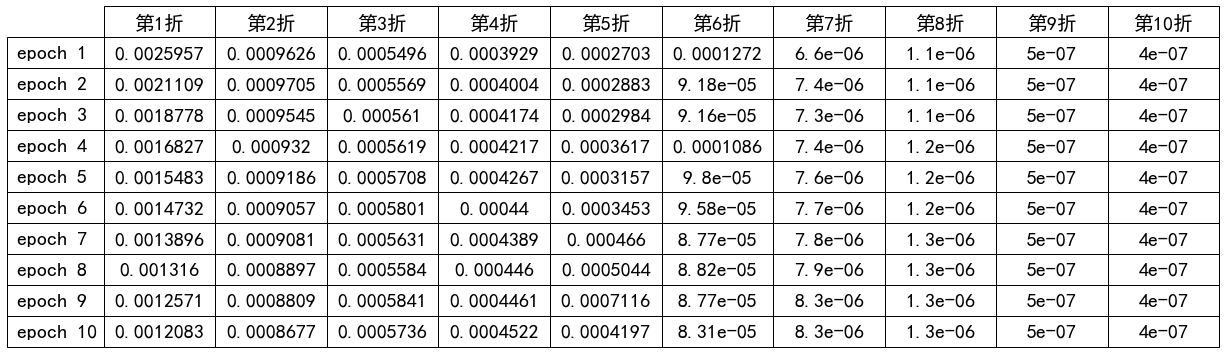

In [127]:
df = DataFrame(data_valid.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)

**使用dropout模型的表现不如不使用的**

In [128]:
class muti_class_LinearNet(nn.Module):
    def __init__(self,num_inputs, num_outputs, num_hiddens):
        super(muti_class_LinearNet,self).__init__()
        self.linear1 = nn.Linear(num_inputs,num_hiddens)
        self.leakrelu = nn.functional.leaky_relu
        self.linear2 = nn.Linear(num_hiddens,num_outputs)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.leakrelu(x,0.2)
        x = self.dropout(x)
        x = self.linear2(x)
        y = self.leakrelu(x,0.2)
        return y

In [129]:
record_k_train_ls, record_k_valid_ls = k_fold(10, mnist_features, mnist_labels,if_reshape=True, num_epochs=10, num_inputs = 784, net = muti_class_LinearNet(784, 10, 600),loss=nn.CrossEntropyLoss())

第 1 折验证结果
epoch: 1, train loss: 0.010120, valid loss: 0.003412
epoch: 2, train loss: 0.003112, valid loss: 0.002708
epoch: 3, train loss: 0.002547, valid loss: 0.002419
epoch: 4, train loss: 0.002252, valid loss: 0.002137
epoch: 5, train loss: 0.002026, valid loss: 0.002009
epoch: 6, train loss: 0.001834, valid loss: 0.001923
epoch: 7, train loss: 0.001718, valid loss: 0.001889
epoch: 8, train loss: 0.001599, valid loss: 0.001768
epoch: 9, train loss: 0.001511, valid loss: 0.001641
epoch: 10, train loss: 0.001413, valid loss: 0.001656
第 2 折验证结果
epoch: 1, train loss: 0.001356, valid loss: 0.001392
epoch: 2, train loss: 0.001300, valid loss: 0.001360
epoch: 3, train loss: 0.001247, valid loss: 0.001293
epoch: 4, train loss: 0.001167, valid loss: 0.001351
epoch: 5, train loss: 0.001143, valid loss: 0.001321
epoch: 6, train loss: 0.001092, valid loss: 0.001287
epoch: 7, train loss: 0.001076, valid loss: 0.001268
epoch: 8, train loss: 0.001045, valid loss: 0.001294
epoch: 9, train loss: 0.0

KeyboardInterrupt: 